In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os, sys

sys.path.insert(0,'../')
from src.utils import load_config, split_into_sentences, flatten_list
from src.stats_analysis import compute_pearson_table, compute_anova_table, compute_wilc_table

from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,TweedieRegressor
from xgboost import XGBRegressor
#from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.svm import SVR
from interpret import show

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt

config = load_config('../config.yaml')

[nltk_data] Downloading package punkt to /home/robin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/robin/env/paraphrase/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
data = pd.read_pickle(os.path.join(config['data_isaac']['folder'],config['data_isaac']['features_file']))
#data.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

factors = ['NegAff', 'NegFTD', 'Eccentric', 'SocAnx', 'PosFTD'] # "ADHD" , "Constrict", "HypoMania", "VivPercept", "F1", "F2"]

density_features = data.filter(regex='score').columns.tolist()

data['cat_enc'] = data['Stim1'].astype('category').cat.codes


data['random_feature'] = np.random.rand(len(data))
sim_features = data.filter(regex='mean|std').columns.tolist()
std_sim_features = data.filter(regex='std').columns.tolist()

mean_sim_metrics = data.filter(regex = '(sentence_sim|jaccard)(.*)(mean)').columns.tolist()
std_sim_metrics = data.filter(regex = '(sentence_sim|jaccard)(.*)(std)').columns.tolist()

all_features = density_features + mean_sim_metrics + std_sim_metrics

print(len(all_features), len(data))

routine = data[data['Stim1']=="routine"]
cinderella = data[data['Stim1']=="cinderella"]

print(len(routine), len(cinderella))

18 2006
969 826


<Axes: xlabel='num_words', ylabel='Count'>

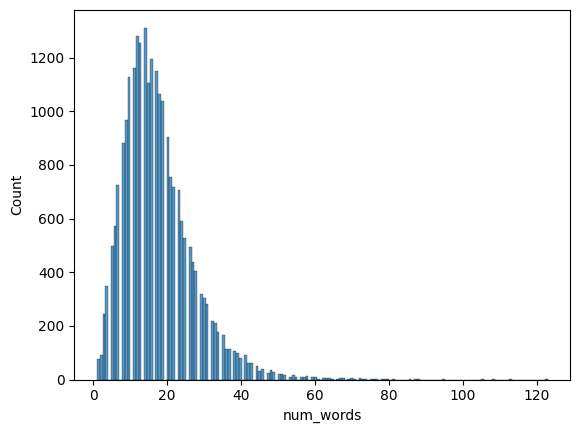

In [5]:
test = pd.DataFrame()
test['num_words'] = flatten_list(data['sentences'].apply(lambda x : [len(elt.split(" ")) for elt in x]).tolist())

sns.histplot(test['num_words'])

In [77]:
data.sample(2)['story'].values[0]

'cinderalla is a fairytale. it about a poor girl who is orphaned and brought up by a stepmother who has 3 2 other daughter s-the ugly sisters111 she has to cook and clean and work for them like a slave whilst they live in luxury and are crul to her. the prince in the castle wants a bride and to be married. he holds a party adn and the sisters and stepmother get themselves invited but cinderalla is not allowed to go. one the night of the party  ball cinderellas friends the mice come to life and she talks to them. she is visited by a fiay godmother who says she can go to the ball as she is a lovely person. the mice are turned by magic into stagecoach footmen. a pumpkin is turned into a stage coach anf cinderalle is given a glowoius dress. she geos to the bal and gets to dance with the actual prince at the castle. she has been told by the godmother that when the clock strikes midnight she has to leave the party or she will be discovered as eveything will turn back to how it was before. th

In [5]:
cinderella['num_sentences'].describe()

count    826.000000
mean      12.937046
std        3.080088
min        4.000000
25%       11.000000
50%       13.000000
75%       15.000000
max       19.000000
Name: num_sentences, dtype: float64

In [3]:
filter_data = data[data.cat_enc.isin([0,2])]
filter_data['cat_enc_bin'] = filter_data['cat_enc'].replace({0:0, 2:1})
compute_wilc_table(filter_data, ['cat_enc_bin'],all_features,seuil=0.05).to_csv('cindrella_vs_routine_wilc.csv')

/tmp/ipykernel_1215443/3452014471.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_data['cat_enc_bin'] = filter_data['cat_enc'].replace({0:0, 2:1})


In [7]:
len(compute_wilc_table(filter_data, ['cat_enc_bin'],all_features,seuil=0.05))

37

In [8]:
compute_anova_table(data[data.cat_enc.isin([0,1,2])], ['cat_enc'], all_features, seuil = 0.05).sort_values('p-unc')

x                                                  y          p-unc  \
7   cat_enc                       regression_error_score_Lasso  1.360650e-270   
34  cat_enc  sentence_sim_all_cosine_sentences_similarity_mean  6.074888e-237   
35  cat_enc   sentence_sim_all_cosine_sentences_similarity_std  1.782362e-140   
32  cat_enc  sentence_sim_consecutive_cosine_sentences_simi...  8.720346e-120   
1   cat_enc             reduction_score_PCA_explained_variance  3.477349e-106   
6   cat_enc                regression_coef_density_score_Lasso  1.768341e-103   
2   cat_enc             reduction_score_PCA_prop_of_components   1.486266e-83   
28  cat_enc            glove_all_wmd_sentences_similarity_mean   5.849250e-79   
33  cat_enc  sentence_sim_consecutive_cosine_sentences_simi...   5.118099e-65   
26  cat_enc         glove_all_cosine_sentences_similarity_mean   1.389821e-47   
30  cat_enc    glove_consecutive_wmd_sentences_similarity_mean   2.031409e-39   
5   cat_enc         cluster_reverse_silhouette_score_MeanShift   3.518380e-39   
19  cat_enc     fast_text_all_cosine_sentences_similarity_mean   1.344038e-33   
24  cat_enc  glove_consecutive_cosine_sentences_similarity_...   2.273878e-31   
8   cat_enc                              reduction_score_Lasso   2.003562e-30   
38  cat_enc        lemma_all_jaccard_sentences_similarity_mean   1.067045e-26   
0   cat_enc                              narrative_speed_score   5.842958e-25   
13  cat_enc              w2v_all_wmd_sentences_similarity_mean   2.812996e-22   
17  cat_enc  fast_text_consecutive_cosine_sentences_similar...   2.219730e-18   
36  cat_enc  lemma_consecutive_jaccard_sentences_similarity...   2.446394e-18   
3   cat_enc                      cluster_density_score_HDBSCAN   5.971207e-15   
21  cat_enc        fast_text_all_wmd_sentences_similarity_mean   7.144518e-14   
15  cat_enc      w2v_consecutive_wmd_sentences_similarity_mean   6.170778e-13   
27  cat_enc          glove_all_cosine_sentences_similarity_std   5.568283e-11   
25  cat_enc  glove_consecutive_cosine_sentences_similarity_std   1.265809e-09   
18  cat_enc  fast_text_consecutive_cosine_sentences_similar...   1.558970e-09   
20  cat_enc      fast_text_all_cosine_sentences_similarity_std   4.582217e-09   
4   cat_enc                    cluster_density_score_MeanShift   1.192445e-07   
11  cat_enc           w2v_all_cosine_sentences_similarity_mean   1.721702e-07   
31  cat_enc     glove_consecutive_wmd_sentences_similarity_std   8.090742e-06   
22  cat_enc  fast_text_consecutive_wmd_sentences_similarity...   2.273492e-05   
37  cat_enc  lemma_consecutive_jaccard_sentences_similarity...   6.468305e-05   
16  cat_enc       w2v_consecutive_wmd_sentences_similarity_std   7.758027e-05   
23  cat_enc  fast_text_consecutive_wmd_sentences_similarity...   2.247211e-04   
9   cat_enc   w2v_consecutive_cosine_sentences_similarity_mean   3.041658e-04   
29  cat_enc             glove_all_wmd_sentences_similarity_std   7.685355e-03   
39  cat_enc         lemma_all_jaccard_sentences_similarity_std   7.959262e-03   
10  cat_enc    w2v_consecutive_cosine_sentences_similarity_std   1.115985e-02   
14  cat_enc               w2v_all_wmd_sentences_similarity_std   1.220694e-02   
12  cat_enc            w2v_all_cosine_sentences_similarity_std   2.646884e-02   

         np2     power  
7   0.462303  1.000000  
34  0.419052  1.000000  
35  0.274796  1.000000  
32  0.239466  1.000000  
1   0.215308  1.000000  
6   0.210410  1.000000  
2   0.173399  1.000000  
28  0.164620  1.000000  
33  0.137408  1.000000  
26  0.102131  1.000000  
30  0.085117  1.000000  
5   0.084615  1.000000  
19  0.072791  1.000000  
24  0.068028  1.000000  
8   0.066001  1.000000  
38  0.057965  1.000000  
0   0.054192  1.000000  
13  0.048341  1.000000  
17  0.039776  1.000000  
36  0.039682  1.000000  
3   0.032174  1.000000  
21  0.029772  1.000000  
15  0.027681  1.000000  
27  0.023300  1.000000  
25  0.020249  1.000000  
18  0.020045  1.000000  
20  0.018990 

In [12]:
## Compute sCCA analysis

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.utils import resample

# X = np.random.rand(100, 20) # Questionnaire items (100 samples, 20 features)
X = data[factors]
# Y = np.random.rand(100, 5)   # Computational variables (100 samples, 5 features)
Y = data[mean_sim_metrics]


# Standardize data
scaler_X = StandardScaler()
scaler_Y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)


# Define CCA with L1 regularization using Lasso
class SparseCCA:
    def __init__(self, n_components=1, alpha=1.0):
        self.n_components = n_components
        self.alpha = alpha
        self.cca = CCA(n_components=n_components)
        self.lasso = Lasso(alpha=alpha)

    def fit(self, X, Y):
        # Fit Lasso to X
        self.lasso.fit(X, Y)
        X_transformed = self.lasso.predict(X).reshape(X.shape[0], -1)

        # Fit CCA to the transformed X and Y
        self.cca.fit(X_transformed, Y)

    def transform(self, X):
        # Predict using Lasso
        X_transformed = self.lasso.predict(X).reshape(X.shape[0], -1)

        # Transform X and Y using CCA
        return self.cca.transform(X_transformed)
    
    def predict(self, X):
        return self.transform(X)

    def fit_transform(self, X, Y):
        self.fit(X, Y)
        return self.transform(X), Y

    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        self.cca = CCA(n_components=self.n_components)
        self.lasso = Lasso(alpha=self.alpha)
        return self

    def get_params(self, deep=True):
        return {'n_components': self.n_components, 'alpha': self.alpha}

# Define a custom scoring function for GridSearchCV
def cca_score(estimator, X, Y):
    X_c, Y_c = estimator.fit_transform(X, Y)
    return np.corrcoef(X_c.T, Y_c.T)[0, 1]

# Create a pipeline with SparseCCA
pipeline = Pipeline([
    ('scca', SparseCCA())
])

# Define parameter grid for GridSearchCV
param_grid = {
    'scca__alpha': np.logspace(-2, 2, 5)
}

# Custom scorer for GridSearchCV
scorer = make_scorer(cca_score, greater_is_better=True)

# Perform GridSearchCV with nested cross-validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=inner_cv, scoring=scorer)
nested_scores = []

for train_index, test_index in outer_cv.split(X_scaled, Y_scaled):
    grid_search.fit(X_scaled[train_index], Y_scaled[train_index])
    best_model = grid_search.best_estimator_
    score = cca_score(best_model.named_steps['scca'], X_scaled[test_index], Y_scaled[test_index])
    nested_scores.append(score)

print(f"Nested Cross-Validation Scores: {nested_scores}")
print(f"Mean Score: {np.mean(nested_scores)}")

# Permutation Test
n_permutations = 50
perm_scores = []

for _ in range(n_permutations):
    Y_permuted = resample(Y_scaled)
    grid_search.fit(X_scaled, Y_permuted)
    best_model = grid_search.best_estimator_
    score = cca_score(best_model.named_steps['scca'], X_scaled, Y_permuted)
    perm_scores.append(score)

# Calculate p-value
observed_score = np.mean(nested_scores)
p_value = np.sum(perm_scores >= observed_score) / n_permutations

print(f"Observed Score: {observed_score}")
print(f"P-Value: {p_value}")

# Projection Deflation
# Deflate the first set of latent variables
X_c, Y_c = best_model.named_steps['scca'].transform(X_scaled)
X_deflated = X_scaled - X_c @ best_model.named_steps['scca'].cca.x_weights_.T
Y_deflated = Y_scaled - Y_c @ best_model.named_steps['scca'].cca.y_weights_.T


/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
TypeError: cca_score() missing 1 required positional argument: 'Y'

  warnings.warn(
/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWa

Nested Cross-Validation Scores: [0.07716823287926913, 0.08096376630128624, 0.07593581378869818, 0.12464222167444694, 0.08877639423518416]
Mean Score: 0.08949728577577694


/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_

Observed Score: 0.08949728577577694
P-Value: 0.0


/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/home/robin/env/paraphrase/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 355, in _score
    return self._sign * self._score_

ValueError: too many values to unpack (expected 2)

In [54]:
import warnings
warnings.filterwarnings('ignore')
def compute_correlation_table(data):
    results = pd.DataFrame()
    for method in ['spearman',"skipped"]:
        r = compute_pearson_table(data, factors,all_features, seuil=0.05, method = method)
        r['method'] = method
        results =  pd.concat([results,r])
    results.reset_index(inplace=True)
    return results

results_all= compute_correlation_table(data)
results_routine = compute_correlation_table(routine)
results_cinderella = compute_correlation_table(cinderella)

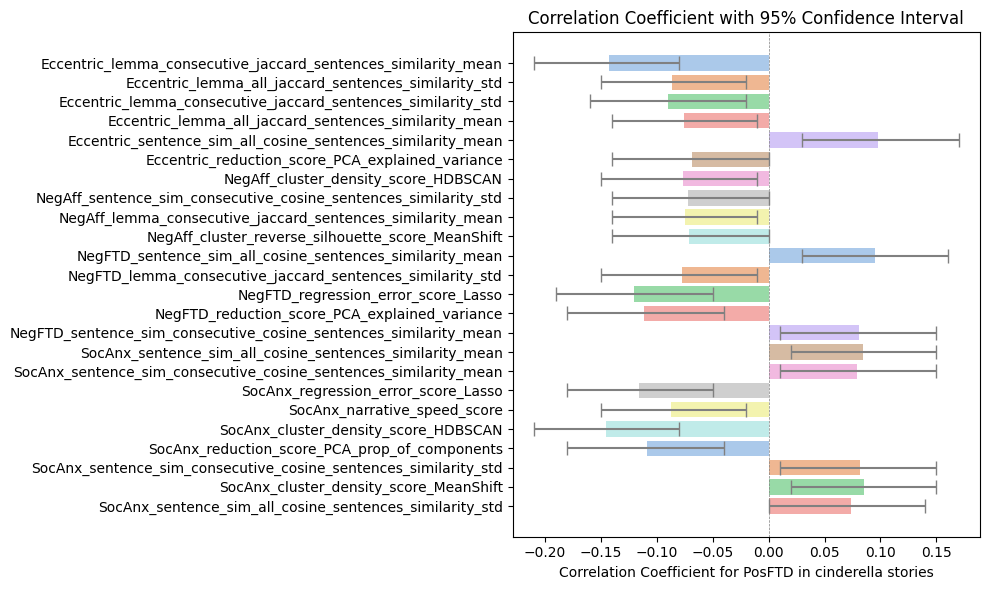

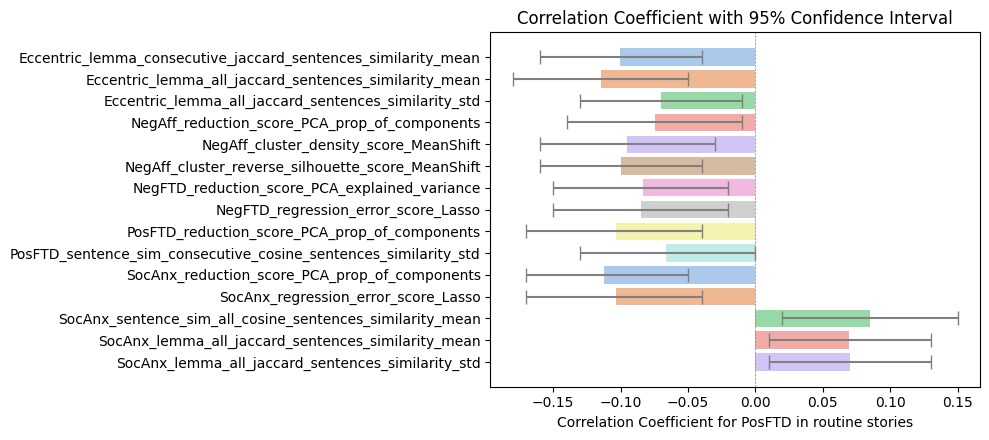

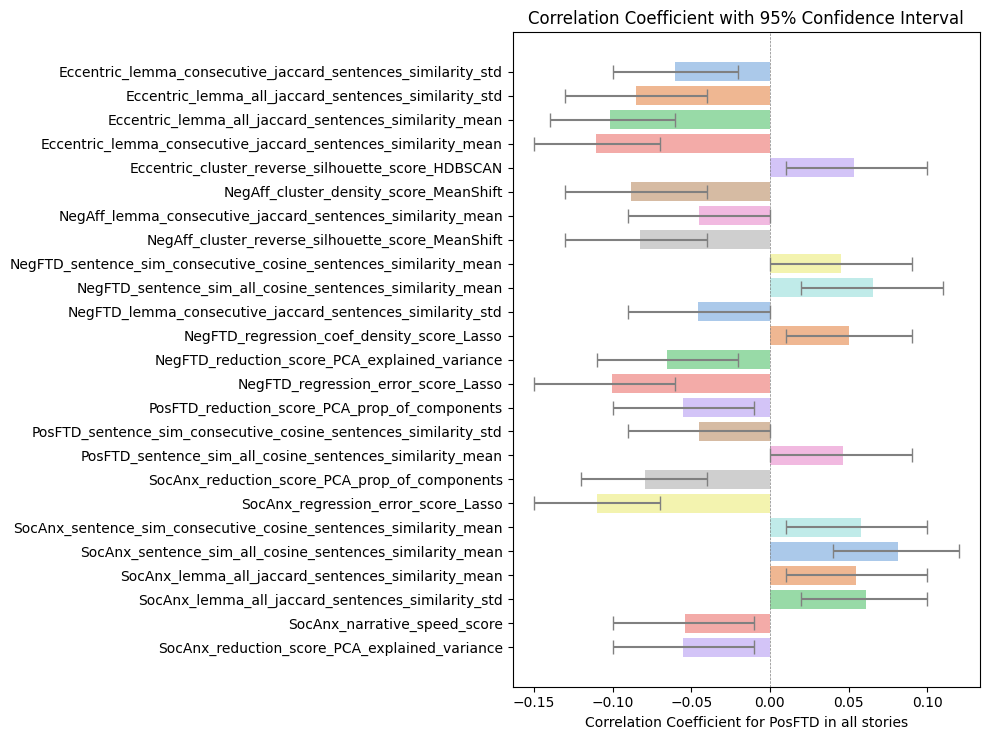

In [80]:

def plot_with_seaborn(df, target_list, name = ""):
    df = df[df['x'].isin(target_list)].sort_values('method')
    # Calculate error bars
    errors = [(coef - ci[0], ci[1] - coef) for coef, ci in zip(df['r'], df['CI95%'])]

    # Plot
    a = max(int(np.sqrt(len(df))),3)
    plt.figure(figsize=(10,a ))

    # Use Seaborn barplot
    sns.barplot(data=df, x='r', y=df.apply(lambda x: f" {x['method']}_{x['y']}", axis=1),
                palette='pastel')

    # Add error bars
    for i, (err, bar) in enumerate(zip(errors, plt.gca().patches)):
        plt.gca().errorbar(bar.get_width(), i, xerr=[[err[0]], [err[1]]], fmt='none', ecolor='gray', capsize=5)

    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Correlation Coefficient with 95% Confidence Interval')
    plt.xlabel(f'Correlation Coefficient for {target} in {name} stories')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

def plot_with_seaborn_all(df, target_list, name = ""):
    df = df[df['x'].isin(target_list)].sort_values('x')
    # Calculate error bars
    errors = [(coef - ci[0], ci[1] - coef) for coef, ci in zip(df['r'], df['CI95%'])]

    # Plot
    a = max(int(np.sqrt(len(df))),3)
    plt.figure(figsize=(10,a*1.5 ))

    # Use Seaborn barplot
    sns.barplot(data=df, x='r', y=df.apply(lambda x: f"{x['x']}_{x['y']}", axis=1),
                palette='pastel')

    # Add error bars
    for i, (err, bar) in enumerate(zip(errors, plt.gca().patches)):
        plt.gca().errorbar(bar.get_width(), i, xerr=[[err[0]], [err[1]]], fmt='none', ecolor='gray', capsize=5)

    plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Correlation Coefficient with 95% Confidence Interval')
    plt.xlabel(f'Correlation Coefficient for {target} in {name} stories')
    plt.ylabel('')
    plt.tight_layout()
    plt.show()

"""
meth = "skipped"
for target in factors:
    plot_with_seaborn(results_all[results_all.method ==meth], [target], name="all")

    plot_with_seaborn(results_routine[results_routine.method==meth], [target], name="routine")

    plot_with_seaborn(results_cinderella[results_cinderella.method == meth], [target], name="cinderella")"""

plot_with_seaborn_all(results_cinderella[results_cinderella.method == "skipped"], factors, name="cinderella")
plot_with_seaborn_all(results_routine[results_routine.method == "skipped"], factors, name="routine")
plot_with_seaborn_all(results_all[results_all.method == "skipped"], factors, name="all")


In [70]:
results_cinderella['feature'] = results_cinderella['x'] + "_" + results_cinderella['y']

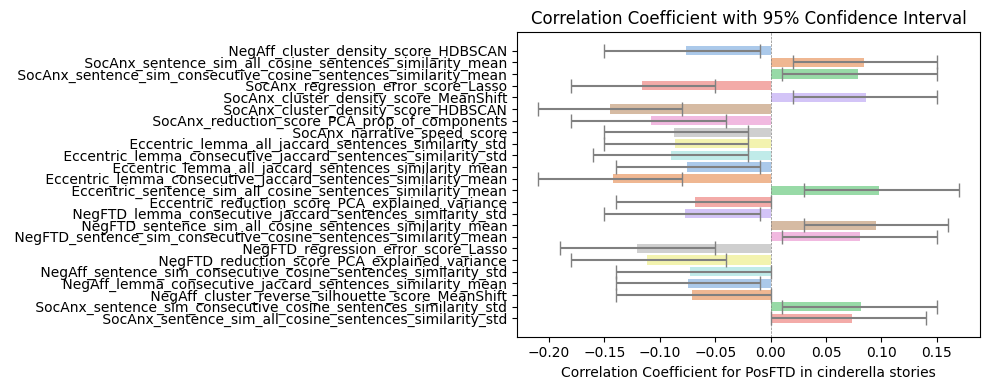

In [72]:
plot_with_seaborn_all(results_cinderella[results_cinderella.method == meth], factors, name="cinderella")

In [60]:
results_all[results_all.method == "skipped"]

index          x                                                  y     n  \
17      0     NegAff                    cluster_density_score_MeanShift  2006   
18      1     NegAff         cluster_reverse_silhouette_score_MeanShift  2006   
19      2     NegAff  lemma_consecutive_jaccard_sentences_similarity...  2006   
20      3     NegFTD             reduction_score_PCA_explained_variance  2006   
21      4     NegFTD                regression_coef_density_score_Lasso  2006   
22      5     NegFTD                       regression_error_score_Lasso  2006   
23      6     NegFTD  sentence_sim_consecutive_cosine_sentences_simi...  2006   
24      7     NegFTD  sentence_sim_all_cosine_sentences_similarity_mean  2006   
25      8     NegFTD  lemma_consecutive_jaccard_sentences_similarity...  2006   
26      9  Eccentric           cluster_reverse_silhouette_score_HDBSCAN  2006   
27     10  Eccentric  lemma_consecutive_jaccard_sentences_similarity...  2006   
28     11  Eccentric        lemma_all_jaccard_sentences_similarity_mean  2006   
29     12  Eccentric  lemma_consecutive_jaccard_sentences_similarity...  2006   
30     13  Eccentric         lemma_all_jaccard_sentences_similarity_std  2006   
31     14     SocAnx                              narrative_speed_score  2006   
32     15     SocAnx             reduction_score_PCA_explained_variance  2006   
33     16     SocAnx             reduction_score_PCA_prop_of_components  2006   
34     17     SocAnx                       regression_error_score_Lasso  2006   
35     18     SocAnx  sentence_sim_consecutive_cosine_sentences_simi...  2006   
36     19     SocAnx  sentence_sim_all_cosine_sentences_similarity_mean  2006   
37     20     SocAnx        lemma_all_jaccard_sentences_similarity_mean  2006   
38     21     SocAnx         lemma_all_jaccard_sentences_similarity_std  2006   
39     22     PosFTD             reduction_score_PCA_prop_of_components  2006   
40     23     PosFTD  sentence_sim_all_cosine_sentences_similarity_mean  2006   
41     24     PosFTD  sentence_sim_consecutive_cosine_sentences_simi...  2006   

           r           CI95%     p-val BF10     power   method  
17 -0.088054  [-0.13, -0.04]  0.000232  NaN  0.957705  skipped  
18 -0.082658  [-0.13, -0.04]  0.000223  NaN  0.958529  skipped  
19  -0.04516   [-0.09, -0.0]  0.044347  NaN  0.520514  skipped  
20 -0.065625  [-0.11, -0.02]  0.003662  NaN   0.82825  skipped  
21  0.049963    [0.01, 0.09]  0.026546  NaN  0.602133  skipped  
22  -0.10037  [-0.15, -0.06]  0.000015  NaN  0.991256  skipped  
23  0.045131     [0.0, 0.09]  0.046243  NaN  0.513492  skipped  
24  0.065648    [0.02, 0.11]  0.003616  NaN  0.829261  skipped  
25 -0.045747   [-0.09, -0.0]  0.041452  NaN  0.531736  skipped  
26  0.053361     [0.01, 0.1]  0.024606  NaN  0.613468  skipped  
27 -0.110676  [-0.15, -0.07]  0.000001  NaN  0.998594  skipped  
28 -0.101686  [-0.14, -0.06]  0.000005  NaN  0.995305  skipped  
29 -0.060444   [-0.1, -0.02]  0.006838  NaN  0.772089  skipped  
30 -0.084882  [-0.13, -0.04]  0.000147  NaN  0.967076  skipped  
31  -0.05379   [-0.1, -0.01]  0.017012  NaN  0.665425  skipped  
32 -0.055319   [-0.1, -0.01]  0.014063  NaN  0.690249  skipped  
33 -0.079635  [-0.12, -0.04]  0.000423  NaN  0.941516  skipped  
34 -0.110072  [-0.15, -0.07]  0.000001  NaN  0.997915  skipped  
35   0.05801     [0.01, 0.1]   0.01015  NaN  0.729636  skipped  
36  0.081198    [0.04, 0.12]  0.000303  NaN  0.951093  skipped  
37   0.05498     [0.01, 0.1]  0.013953  NaN  0.691247  skipped  
38  0.060949     [0.02, 0.1]  0.006739  NaN  0.773556  skipped  
39 -0.055064   [-0.1, -0.01]  0.015231  NaN  0.680013  skipped  
40  0.046249     [0.0, 0.09]  0.040934  NaN  0.533816  skipped  
41 -0.044892   [-0.09, -0.0]    0.0459  NaN   0.51474  skipped

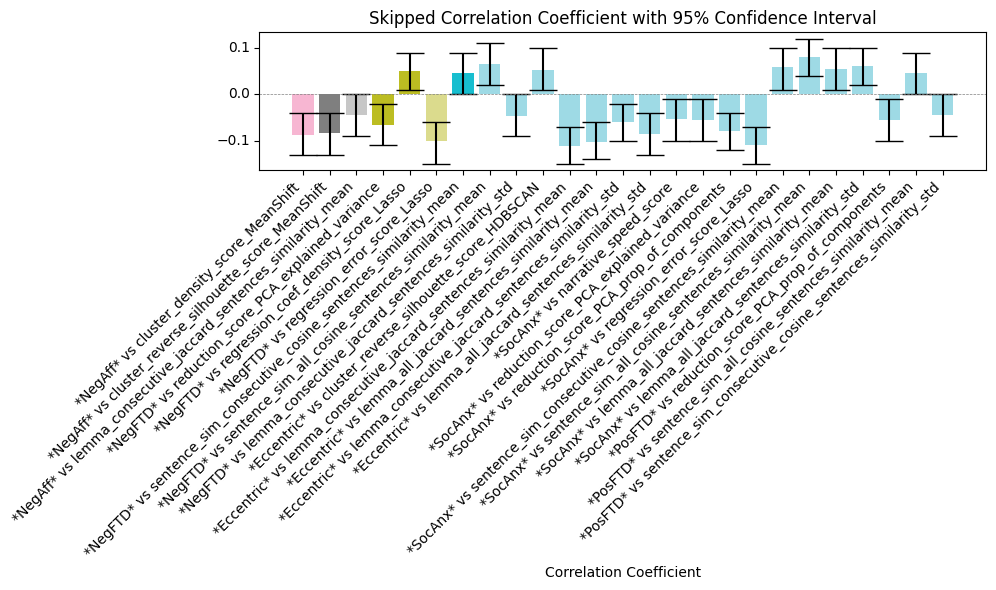

In [65]:
import matplotlib.cm as cm
def plot(df):
    plt.figure(figsize=(10, 6))
    cmap = cm.get_cmap('tab20')

    # Plot bars for each row in the DataFrame
    for i, row in df.iterrows():
        feature_pair = f"*{row['x']}* vs {row['y']}"
        corr_coef = row['r']
        ci = row['CI95%']
        color = cmap(i / len(df))
        plt.bar( feature_pair,corr_coef, yerr=[[corr_coef - ci[0]], [ci[1] - corr_coef]], capsize=10,color=color)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    #plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Skipped Correlation Coefficient with 95% Confidence Interval')
    plt.xlabel('Correlation Coefficient')
    plt.yticks(rotation=0, va='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot(results_all[results_all.method =="skipped"])

In [18]:
data.filter(regex ="score").columns.tolist()

['narrative_speed_score',
 'reduction_score_PCA_explained_variance',
 'reduction_score_PCA_prop_of_components',
 'cluster_density_score_HDBSCAN',
 'cluster_reverse_silhouette_score_HDBSCAN',
 'cluster_density_score_MeanShift',
 'cluster_reverse_silhouette_score_MeanShift',
 'regression_coef_density_score_Lasso',
 'regression_error_score_Lasso',
 'reduction_score_Lasso']

In [45]:
import pingouin as pg

scores = data.filter(regex='score').columns.tolist()
mean_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text|jaccard)(.*)(mean)').columns.tolist()
std_sim_metrics = data.filter(regex = '(sentence_sim|w2v|glove|fast_text|jaccard)(.*)(std)').columns.tolist()
all_features = scores + mean_sim_metrics + std_sim_metrics

def compute_cohen(score_list, routine,cinderella):
    cohen  = pd.DataFrame(columns=['feature_x','cohen_d'])
    for i,score in enumerate(score_list):
        x = routine[score].tolist()
        y = cinderella[score].tolist()
        d = pg.compute_effsize(y, x, paired=False, eftype='cohen')
        cohen.loc[i] = pd.Series({'feature_x':score, 'feature_y':score, 'cohen_d':d})
    return cohen

cohen_density = compute_cohen(scores, routine,cinderella)
cohen_mean_sim = compute_cohen(mean_sim_metrics, routine,cinderella)
cohen_std_sim = compute_cohen(std_sim_metrics, routine,cinderella)
cohen_all = compute_cohen(all_features, routine,cinderella)

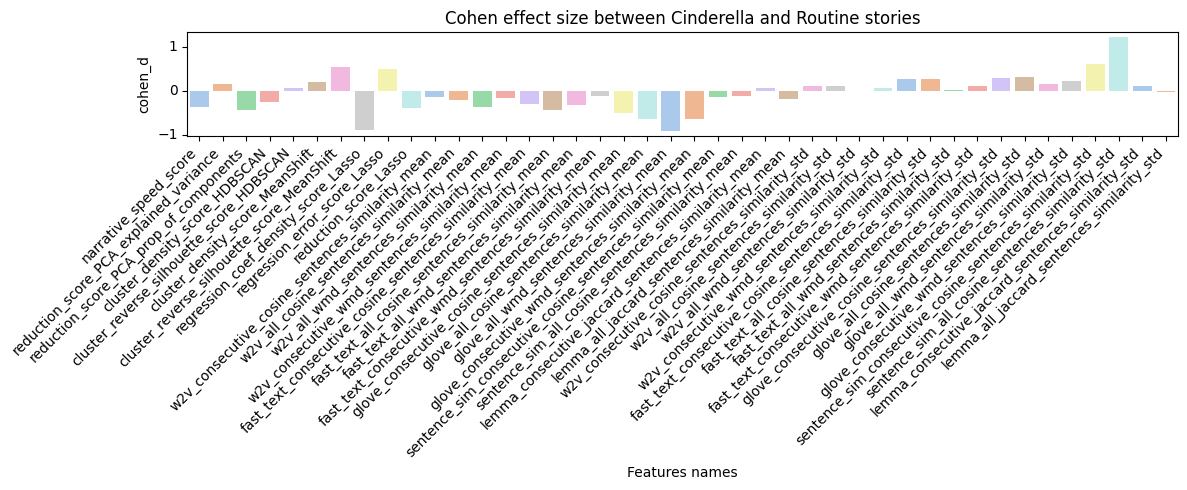

In [51]:
#fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.figure(figsize=(12,5))
sns.barplot(cohen_all, x = 'feature_x', y = 'cohen_d', palette='pastel',errorbar = "se", )
#sns.barplot(cohen_std_sim, x = 'feature_x', y = 'cohen_d', palette='pastel',errorbar = "se", ax=axes[1])
#sns.barplot(cohen_density, x = 'feature_x', y = 'cohen_d', palette='pastel',errorbar = "se", ax=axes[2])
plt.title('Cohen effect size between Cinderella and Routine stories')
plt.xlabel('Features names')
plt.yticks(rotation=0, va='center')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [52]:
sns.kdeplot(data, x=col, hue=scores)

ValueError: Length of list vectors must match length of `data` when both are used, but `data` has length 2006 and the vector passed to `hue` has length 10.

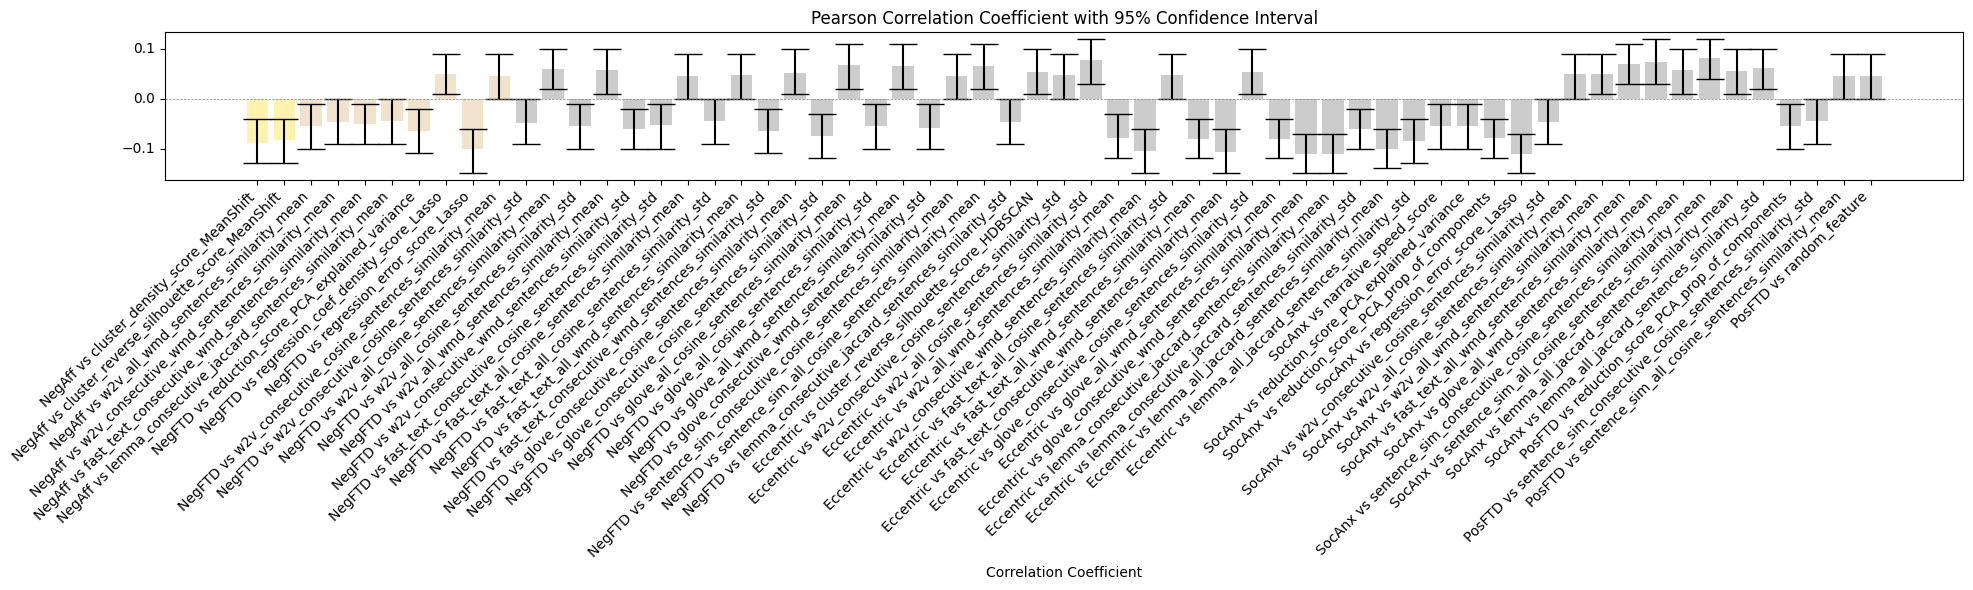

In [12]:
import matplotlib.cm as cm
def plot(df):
    plt.figure(figsize=(20, 6))
    cmap = cm.get_cmap('Pastel2')

    # Plot bars for each row in the DataFrame
    for i, row in df.iterrows():
        feature_pair = f"{row['x']} vs {row['y']}"
        corr_coef = row['r']
        ci = row['CI95%']
        color = cmap(i / len(df))
        plt.bar( feature_pair,corr_coef, yerr=[[corr_coef - ci[0]], [ci[1] - corr_coef]], capsize=10,color=color)

    plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    #plt.axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    plt.title('Pearson Correlation Coefficient with 95% Confidence Interval')
    plt.xlabel('Correlation Coefficient')
    plt.yticks(rotation=0, va='center')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot(results_all[results_all.method =="skipped"])

In [10]:
results_all

index       x                                                  y     n  \
0        0  NegAff                    cluster_density_score_MeanShift  2006   
1        1  NegAff         cluster_reverse_silhouette_score_MeanShift  2006   
2        2  NegFTD             reduction_score_PCA_explained_variance  2006   
3        3  NegFTD                regression_coef_density_score_Lasso  2006   
4        4  NegFTD                       regression_error_score_Lasso  2006   
..     ...     ...                                                ...   ...   
100     56  SocAnx         lemma_all_jaccard_sentences_similarity_std  2006   
101     57  PosFTD             reduction_score_PCA_prop_of_components  2006   
102     58  PosFTD  sentence_sim_consecutive_cosine_sentences_simi...  2006   
103     59  PosFTD  sentence_sim_all_cosine_sentences_similarity_mean  2006   
104     60  PosFTD                                     random_feature  2006   

            r           CI95%     p-val BF10     power    method  
0   -0.077187  [-0.12, -0.03]   0.00054  NaN  0.933477  spearman  
1   -0.084822  [-0.13, -0.04]  0.000143  NaN  0.967571  spearman  
2   -0.064824  [-0.11, -0.02]  0.003677  NaN   0.82791  spearman  
3    0.048344     [0.0, 0.09]  0.030374  NaN  0.581561  spearman  
4    -0.07051  [-0.11, -0.03]  0.001578  NaN  0.885251  spearman  
..        ...             ...       ...  ...       ...       ...  
100  0.060949     [0.02, 0.1]  0.006739  NaN  0.773556   skipped  
101 -0.055064   [-0.1, -0.01]  0.015231  NaN  0.680013   skipped  
102 -0.044892   [-0.09, -0.0]    0.0459  NaN   0.51474   skipped  
103  0.046249     [0.0, 0.09]  0.040934  NaN  0.533816   skipped  
104  0.045658     [0.0, 0.09]  0.042109  NaN  0.529137   skipped  

[105 rows x 10 columns]

In [13]:
target = ['NegAff']
results = compute_pearson_table(cinderella, factors,all_features, seuil=0.05, method = "pearson")
results.sort_values(by='r') #.to_csv('results_pearson.csv')

x                                                  y    n  \
32     SocAnx                       regression_error_score_Lasso  826   
27  Eccentric  lemma_consecutive_jaccard_sentences_similarity...  826   
7      NegFTD             reduction_score_PCA_explained_variance  826   
22     NegFTD  lemma_consecutive_jaccard_sentences_similarity...  826   
9      NegFTD                       regression_error_score_Lasso  826   
14     NegFTD  fast_text_consecutive_wmd_sentences_similarity...  826   
31     SocAnx             reduction_score_PCA_prop_of_components  826   
28  Eccentric  lemma_consecutive_jaccard_sentences_similarity...  826   
19     NegFTD     glove_consecutive_wmd_sentences_similarity_std  826   
29  Eccentric         lemma_all_jaccard_sentences_similarity_std  826   
24  Eccentric      w2v_consecutive_wmd_sentences_similarity_mean  826   
23     NegFTD         lemma_all_jaccard_sentences_similarity_std  826   
0      NegAff         cluster_reverse_silhouette_score_MeanShift  826   
25  Eccentric  fast_text_consecutive_wmd_sentences_similarity...  826   
26  Eccentric    glove_consecutive_wmd_sentences_similarity_mean  826   
1      NegAff      w2v_consecutive_wmd_sentences_similarity_mean  826   
4      NegAff  sentence_sim_consecutive_cosine_sentences_simi...  826   
5      NegAff  lemma_consecutive_jaccard_sentences_similarity...  826   
2      NegAff  fast_text_consecutive_wmd_sentences_similarity...  826   
18     NegFTD             glove_all_wmd_sentences_similarity_std  826   
12     NegFTD  fast_text_consecutive_cosine_sentences_similar...  826   
30     SocAnx             reduction_score_PCA_explained_variance  826   
3      NegAff     glove_consecutive_wmd_sentences_similarity_std  826   
10     NegFTD              w2v_all_wmd_sentences_similarity_mean  826   
33     SocAnx        fast_text_all_wmd_sentences_similarity_mean  826   
36     PosFTD                              reduction_score_Lasso  826   
8      NegFTD                regression_coef_density_score_Lasso  826   
11     NegFTD  fast_text_consecutive_cosine_sentences_similar...  826   
15     NegFTD  glove_consecutive_cosine_sentences_similarity_...  826   
20     NegFTD  sentence_sim_consecutive_cosine_sentences_simi...  826   
6      NegFTD                              narrative_speed_score  826   
16     NegFTD         glove_all_cosine_sentences_similarity_mean  826   
17     NegFTD            glove_all_wmd_sentences_similarity_mean  826   
34     SocAnx  sentence_sim_consecutive_cosine_sentences_simi...  826   
13     NegFTD     fast_text_all_cosine_sentences_similarity_mean  826   
21     NegFTD  sentence_sim_all_cosine_sentences_similarity_mean  826   
35     SocAnx  sentence_sim_all_cosine_sentences_similarity_mean  826   

           r           CI95%     p-val     BF10     power  
32 -0.146297  [-0.21, -0.08]  0.000024  317.164  0.988388  
27 -0.140574  [-0.21, -0.07]   0.00005  159.247  0.982223  
7  -0.130441   [-0.2, -0.06]   0.00017   50.428  0.964515  
22  -0.11659  [-0.18, -0.05]  0.000787   12.091   0.91953  
9  -0.113493  [-0.18, -0.05]  0.001085    8.985  0.905209  
14 -0.110963  [-0.18, -0.04]  0.001403    7.094  0.892189  
31 -0.105543  [-0.17, -0.04]  0.002388    4.355  0.860118  
28 -0.102958  [-0.17, -0.03]  0.003052    3.481  0.842746  
19 -0.100797  [-0.17, -0.03]  0.003732    2.899  0.827195  
29 -0.095656  [-0.16, -0.03]  0.005936    1.906  0.786437  
24 -0.094069  [-0.16, -0.03]  0.006821    1.683  0.772822  
23   -0.0921  [-0.16, -0.02]  0.008083    1.445  0.755261  
0  -0.088524  [-0.16, -0.02]  0.010917    1.106  0.721618  
25  -0.08635  [-0.15, -0.02]  0.013043    0.945   0.70013  
26 -0.082966  [-0.15, -0.01]  0.017081    0.745  0.665286  
1  -0.078191  [-0.15, -0.01]  0.024624    0.542  0.613703  
4  -0.078188  [-0.15, -0.01]  0.024629    0.542  0.613673  
5  -0.072937   [-0.14, -0.0]  0.036096     0.39  0.554618  
2  -0.071011   [-0.14, -0.0]  0.041316    0.348  0.532585  
18 -0.070525   [-0.14, -0.0]   0.0427

In [248]:

results = compute_pearson_table(cinderella, factors,all_features, seuil=0.05, method="kendall")
results.sort_values(by='p-val')

x                                                  y    n  \
6   Eccentric         lemma_all_jaccard_sentences_similarity_std  832   
5   Eccentric  lemma_consecutive_jaccard_sentences_similarity...  832   
24     SocAnx        lemma_all_jaccard_sentences_similarity_mean  832   
23     SocAnx  sentence_sim_all_cosine_sentences_similarity_m...  832   
21     SocAnx  sentence_sim_consecutive_cosine_sentences_simi...  832   
25     SocAnx      lemma_all_jaccard_sentences_similarity_median  832   
28     PosFTD  lemma_consecutive_jaccard_sentences_similarity...  832   
4   Eccentric  lemma_consecutive_jaccard_sentences_similarity...  832   
19     SocAnx  glove_consecutive_wmd_sentences_similarity_median  832   
15     SocAnx  fast_text_consecutive_wmd_sentences_similarity...  832   
20     SocAnx  sentence_sim_consecutive_cosine_sentences_simi...  832   
22     SocAnx  sentence_sim_all_cosine_sentences_similarity_mean  832   
3   Eccentric      w2v_consecutive_wmd_sentences_similarity_mean  832   
11     SocAnx     fast_text_all_cosine_sentences_similarity_mean  832   
13     SocAnx        fast_text_all_wmd_sentences_similarity_mean  832   
26     PosFTD            w2v_all_cosine_sentences_similarity_std  832   
14     SocAnx      fast_text_all_wmd_sentences_similarity_median  832   
9      SocAnx  fast_text_consecutive_cosine_sentences_similar...  832   
7      SocAnx             reduction_score_PCA_prop_of_components  832   
17     SocAnx         glove_all_cosine_sentences_similarity_mean  832   
1      NegAff     glove_consecutive_wmd_sentences_similarity_std  832   
27     PosFTD  fast_text_consecutive_wmd_sentences_similarity...  832   
18     SocAnx            glove_all_wmd_sentences_similarity_mean  832   
2      NegFTD  lemma_consecutive_jaccard_sentences_similarity...  832   
12     SocAnx   fast_text_all_cosine_sentences_similarity_median  832   
29     PosFTD         lemma_all_jaccard_sentences_similarity_min  832   
8      SocAnx            w2v_all_wmd_sentences_similarity_median  832   
16     SocAnx  glove_consecutive_cosine_sentences_similarity_...  832   
10     SocAnx  fast_text_consecutive_cosine_sentences_similar...  832   
0      NegAff  fast_text_consecutive_cosine_sentences_similar...  832   

           r           CI95%     p-val BF10     power  
6  -0.078087  [-0.15, -0.01]  0.000749  NaN  0.615674  
5  -0.070576   [-0.14, -0.0]  0.002314  NaN  0.530531  
24  0.067331    [-0.0, 0.13]  0.003653  NaN  0.493108  
23  0.065312    [-0.0, 0.13]   0.00481  NaN  0.469838  
21  0.065167    [-0.0, 0.13]  0.004904  NaN  0.468174  
25  0.061047   [-0.01, 0.13]  0.008741  NaN   0.42115  
28 -0.059554   [-0.13, 0.01]  0.010668  NaN  0.404368  
4   -0.05909   [-0.13, 0.01]  0.010746  NaN  0.399185  
19  0.056523   [-0.01, 0.12]  0.014684  NaN  0.370869  
15  0.056511   [-0.01, 0.12]  0.014704  NaN  0.370743  
20  0.056037   [-0.01, 0.12]  0.015559  NaN  0.365583  
22  0.055273   [-0.01, 0.12]  0.017027  NaN  0.357331  
3  -0.055005   [-0.12, 0.01]  0.017572  NaN  0.354451  
11  0.054318   [-0.01, 0.12]  0.019032  NaN  0.347112  
13  0.052756   [-0.02, 0.12]  0.022758  NaN  0.330639  
26  0.051637   [-0.02, 0.12]  0.025821  NaN  0.319044  
14  0.051547   [-0.02, 0.12]  0.026064  NaN  0.318115  
9   0.050279   [-0.02, 0.12]  0.029965  NaN   0.30522  
7  -0.052195   [-0.12, 0.02]  0.030177  NaN    0.3248  
17  0.049822   [-0.02, 0.12]   0.03149  NaN  0.300629  
1  -0.049082   [-0.12, 0.02]  0.034103  NaN  0.293264  
27  -0.04903   [-0.12, 0.02]  0.034294  NaN  0.292749  
18   0.04896   [-0.02, 0.12]  0.034549  NaN  0.292056  
2   -0.04809   [-0.12, 0.02]  0.037893  NaN   0.28353  
12   0.04789   [-0.02, 0.12]  0.038697  NaN  0.281582  
29 -0.048649   [-0.12, 0.02]  0.038708  NaN  0.288991  
8   0.047409   [-0.02, 0.12]  0.040691  NaN  0.276944  
16   0.04721   [-0.02, 0.11]  0.041546  NaN  0.275029  
10  0.045575   [-0.02, 0.11]  0.049128  NaN  0.259601  
0  -0.045547   [-0.11, 0.02]  0.049272  NaN  0.259338

In [249]:
results = compute_pearson_table(routine, factors,all_features, seuil=0.05, method="kendall")
results.sort_values(by='p-val')

x                                                  y    n  \
10  Eccentric         lemma_all_jaccard_sentences_similarity_std  903   
3   Eccentric                   cluster_silhouette_score_HDBSCAN  903   
20     SocAnx  sentence_sim_all_cosine_sentences_similarity_mean  903   
17     SocAnx            glove_all_wmd_sentences_similarity_mean  903   
21     SocAnx  sentence_sim_all_cosine_sentences_similarity_m...  903   
14     SocAnx        fast_text_all_wmd_sentences_similarity_mean  903   
8   Eccentric  lemma_consecutive_jaccard_sentences_similarity...  903   
12     SocAnx         w2v_all_cosine_sentences_similarity_median  903   
15     SocAnx      fast_text_all_wmd_sentences_similarity_median  903   
0      NegAff  sentence_sim_consecutive_cosine_sentences_simi...  903   
6   Eccentric      w2v_consecutive_wmd_sentences_similarity_mean  903   
18     SocAnx          glove_all_wmd_sentences_similarity_median  903   
23     SocAnx        lemma_all_jaccard_sentences_similarity_mean  903   
16     SocAnx  fast_text_consecutive_wmd_sentences_similarity...  903   
5   Eccentric               w2v_all_wmd_sentences_similarity_std  903   
2      NegFTD             glove_all_wmd_sentences_similarity_std  903   
7   Eccentric  sentence_sim_consecutive_cosine_sentences_simi...  903   
1      NegFTD                regression_coef_density_score_Lasso  903   
9   Eccentric  lemma_consecutive_jaccard_sentences_similarity...  903   
19     SocAnx  sentence_sim_consecutive_cosine_sentences_simi...  903   
22     SocAnx  lemma_consecutive_jaccard_sentences_similarity...  903   
4   Eccentric            w2v_all_wmd_sentences_similarity_median  903   
11     SocAnx  w2v_consecutive_cosine_sentences_similarity_me...  903   
13     SocAnx              w2v_all_wmd_sentences_similarity_mean  903   

           r          CI95%     p-val BF10     power  
10 -0.062857   [-0.13, 0.0]  0.004693  NaN  0.471809  
3  -0.058621  [-0.12, 0.01]  0.009381  NaN  0.421424  
20  0.057179  [-0.01, 0.12]  0.010112  NaN  0.404539  
17  0.056781  [-0.01, 0.12]  0.010646  NaN   0.39991  
21  0.056732  [-0.01, 0.12]  0.010714  NaN  0.399339  
14  0.055283  [-0.01, 0.12]  0.012893  NaN  0.382614  
8  -0.054738  [-0.12, 0.01]  0.013809  NaN  0.376377  
12  0.053147  [-0.01, 0.12]  0.016826  NaN  0.358373  
15  0.052734  [-0.01, 0.12]   0.01769  NaN  0.353749  
0   0.051978  [-0.01, 0.12]  0.019386  NaN   0.34534  
6  -0.051796  [-0.12, 0.01]  0.019814  NaN  0.343331  
18  0.050003  [-0.02, 0.11]  0.024499  NaN  0.323767  
23  0.049654  [-0.02, 0.11]  0.025515  NaN  0.320017  
16  0.049217  [-0.02, 0.11]  0.026839  NaN  0.315343  
5  -0.048377  [-0.11, 0.02]  0.029549  NaN  0.306449  
2   0.047013  [-0.02, 0.11]  0.034459  NaN   0.29225  
7  -0.046491  [-0.11, 0.02]  0.036507  NaN  0.286909  
1   0.047832  [-0.02, 0.11]  0.037006  NaN  0.300737  
9  -0.044659  [-0.11, 0.02]  0.044555  NaN  0.268537  
19  0.043913  [-0.02, 0.11]   0.04824  NaN  0.261231  
22  0.044094  [-0.02, 0.11]  0.048767  NaN  0.262996  
4  -0.043721  [-0.11, 0.02]  0.049225  NaN  0.259374  
11  0.043711  [-0.02, 0.11]  0.049289  NaN  0.259279  
13  0.043706  [-0.02, 0.11]  0.049302  NaN  0.259232

In [157]:
target = ['PosFTD']
results = compute_pearson_table(data, target,all_features, seuil=0.05)
results.sort_values(by='p-val')

/home/robin/env/paraphrase/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


x                              y     n         r          CI95%  \
0  PosFTD  cluster_density_score_HDBSCAN  1935 -0.047297  [-0.09, -0.0]   

      p-val   BF10     power  
0  0.037495  0.248  0.548165

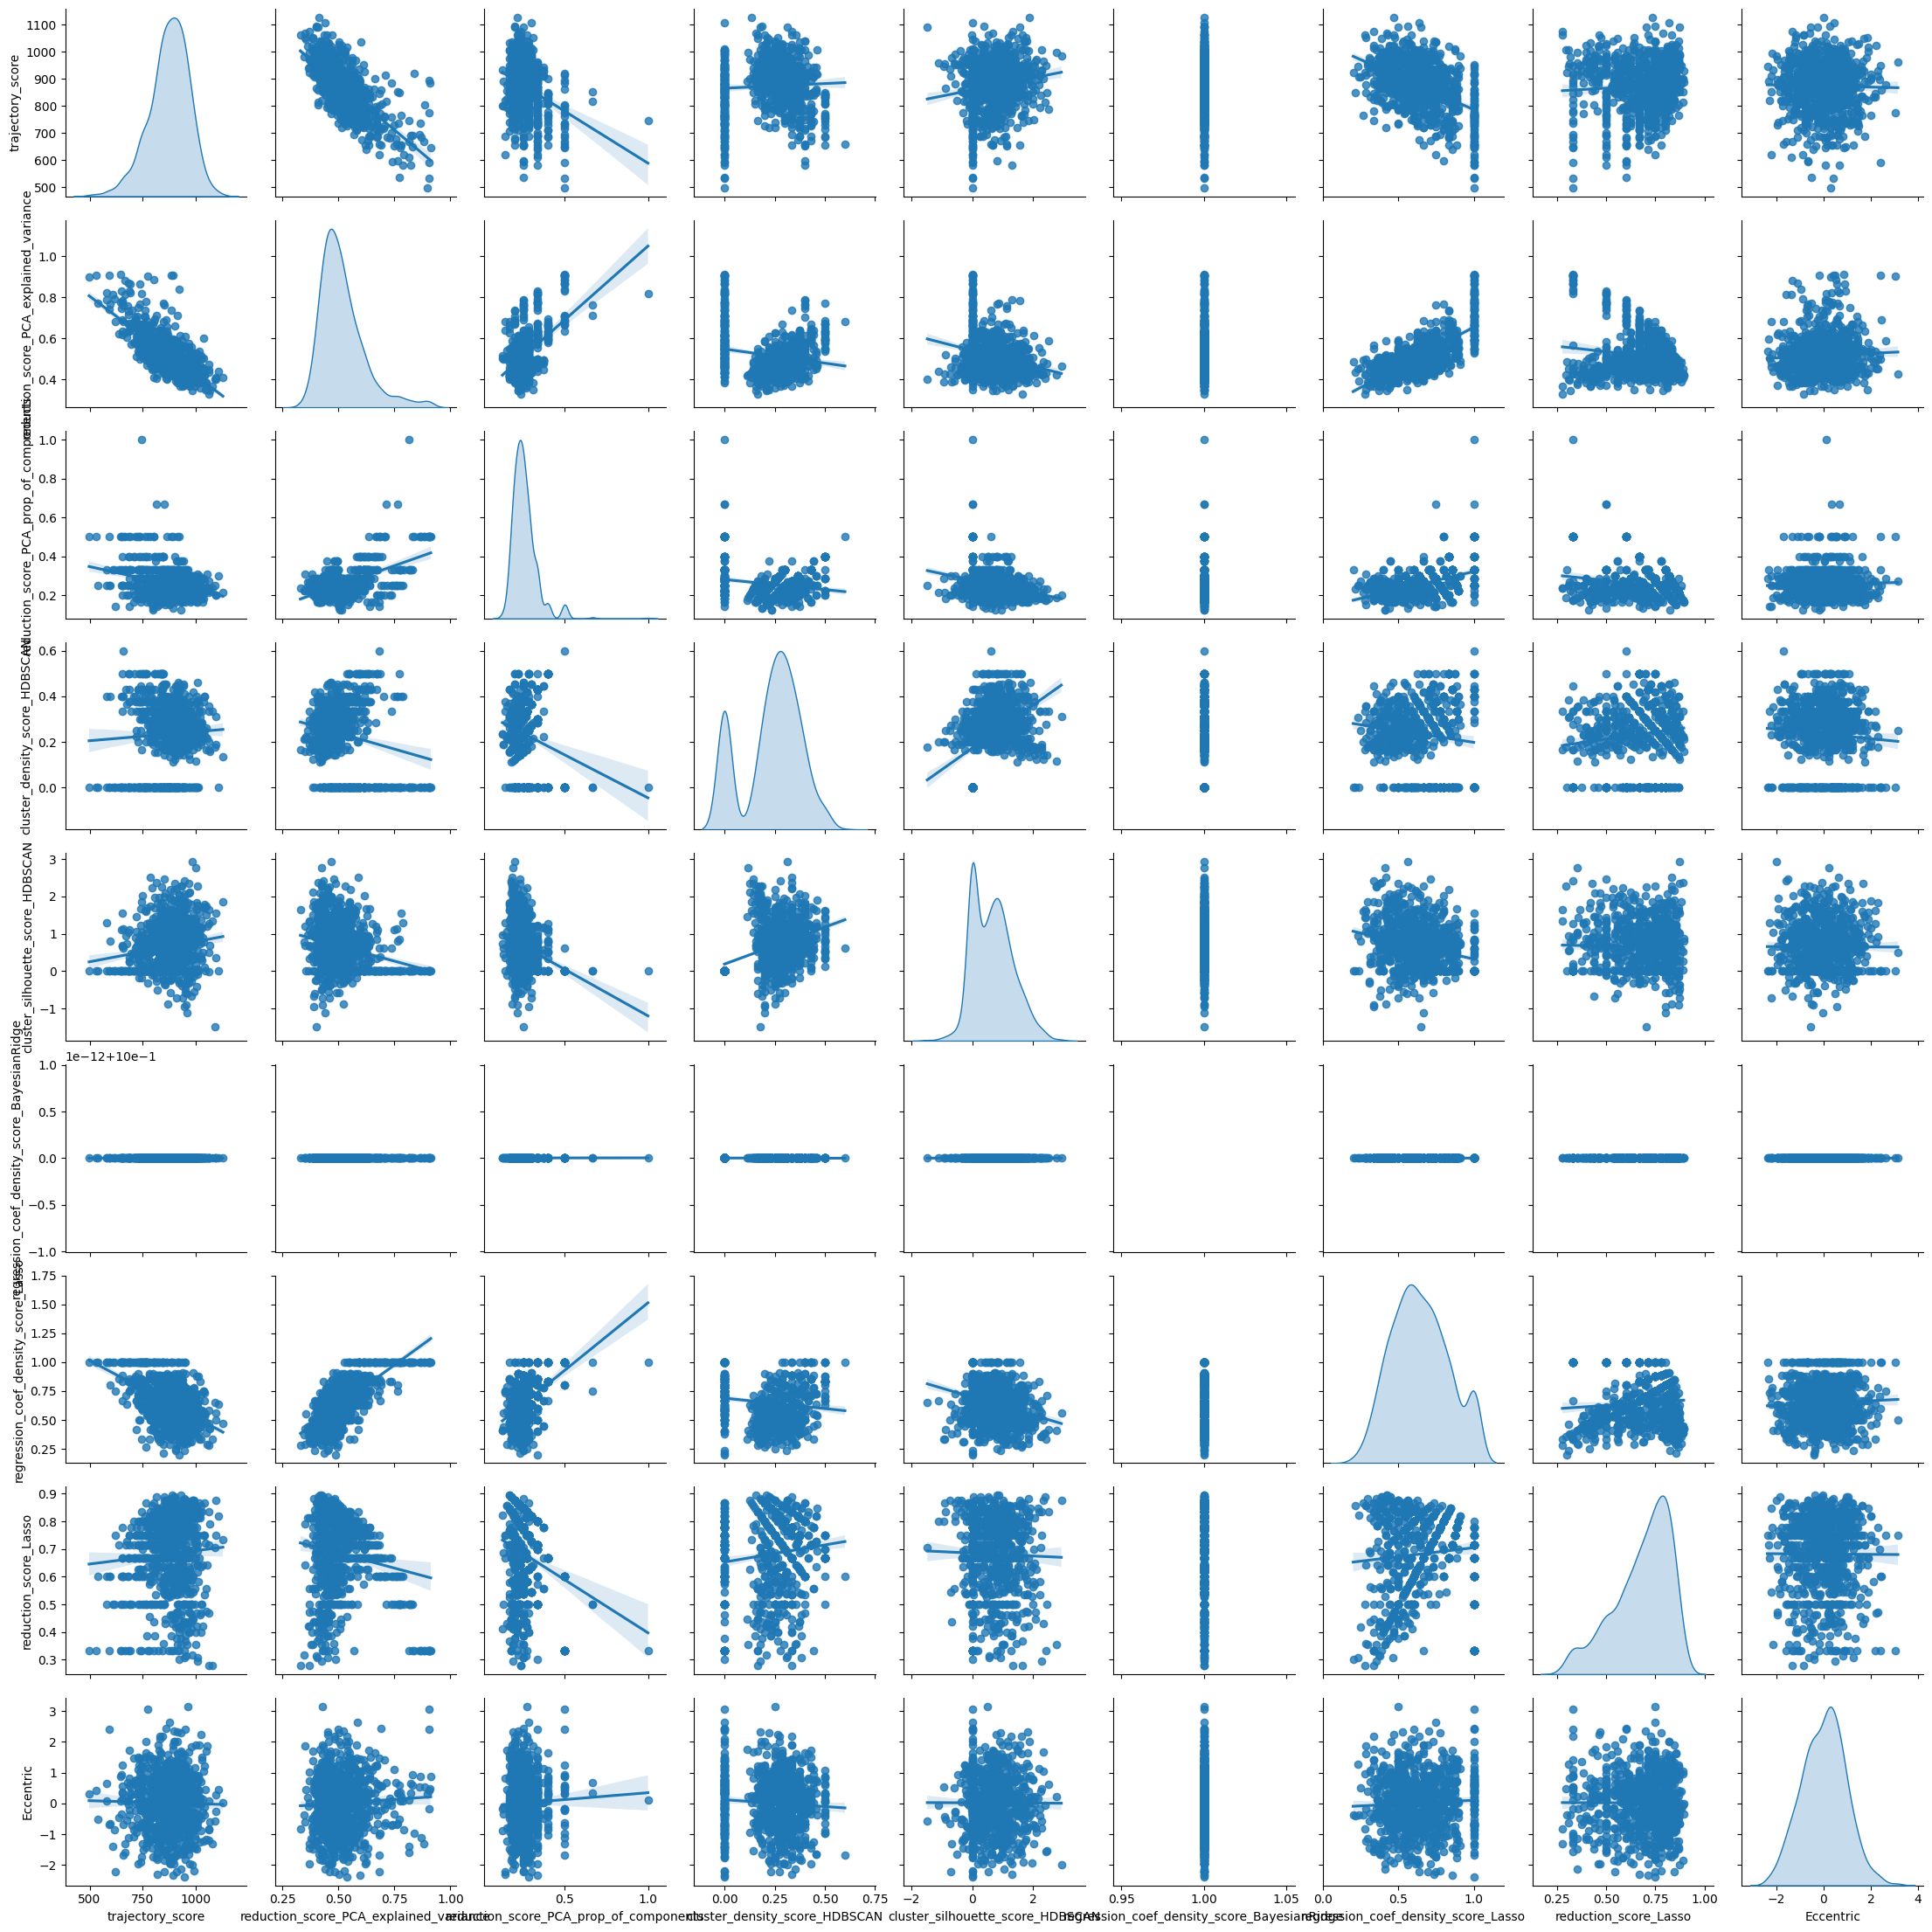

In [250]:
import seaborn as sns

sns.pairplot(cinderella[density_features + ['Eccentric']], kind="reg", diag_kind="kde")

In [53]:
data['id'] = data.index
target = "NegAff"
data['target'] = data[target] + data[target].max()
df_train, df_test = train_test_split(data[all_features+['target',"id"]], test_size=0.2, random_state=42)
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

In [52]:
df_test.target.describe()

count    387.000000
mean       3.167649
std        0.930600
min        1.210000
25%        2.524000
50%        3.132000
75%        3.710500
max        6.147000
Name: target, dtype: float64

In [49]:
data['NegFTD'].describe()

count    1935.000000
mean        0.014883
std         0.925461
min        -2.349000
25%        -0.636000
50%        -0.026000
75%         0.578000
max         3.173000
Name: NegFTD, dtype: float64

In [46]:
df_train.to_csv('train.csv')
df_test.to_csv('test.csv')

In [67]:

from sklearn.manifold import TSNE

def evaluate_regression(y_test, y_pred):
    results = {}
    results["R2"]  =  r2_score(y_test, y_pred)
    results["MSE"] = mean_squared_error(y_test, y_pred)
    results["rMSE"] = np.sqrt(mean_squared_error(y_test, y_pred))
    results["MAE"] = mean_absolute_error(y_test, y_pred)
    return results

def select_features(X_train, y_train, X_test, k=10):
    # configure to select all features
    if k =="False":
        k = "all"
    fs = SelectKBest(score_func=f_regression, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

def get_train_test_split(data, features, target, test_size=0.2, select = False, tsne=False):

    X = data[features]
    if tsne:
        reduce = TSNE(n_components=2)
        X = reduce.fit_transform(X)
        select = False
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=2)
    if select:
        X_train, X_test, fs = select_features(X_train, y_train, X_test,k = select)
    return X_train, X_test, y_train, y_test

def get_regression_synthesis(data, features, target, model_list, test_size=0.2, select = False, dataset_name = "", tsne = False):
    X_train, X_test, y_train, y_test = get_train_test_split(data, features, target, test_size=test_size, select=select, tsne=tsne)
    df_results = pd.DataFrame(columns=['MODEL', 'R2', 'MSE', "rMSE",'MAE','model_name',"test_size","target","select","dataset_name",'tsne'])
    for i,model in enumerate(model_list):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_train_pred = model.predict(X_train)
        r = evaluate_regression(y_test, y_pred)
        r_train = evaluate_regression(y_train, y_train_pred)
        print("TRAIN")
        print(r_train)
        print("TEST")
        print(r)
        r['MODEL'] = model
        r['model_name'] = model.__class__.__name__
        r['test_size']= test_size
        r['target'] = target
        r['select'] = select
        r['tsne'] = tsne
        #r['score'] = model.score(X_test, y_test)
        r['dataset_name'] = dataset_name
        df_results.loc[i] = pd.Series(r)

    return df_results


model_list = [LinearRegression(), ExplainableBoostingRegressor(), RandomForestRegressor(n_estimators=10, max_depth=10),
              #SVR(kernel="linear"),
              SVR(kernel="rbf", C=0.5, gamma=0.1, epsilon=0.1),
              XGBRegressor(n_estimators=100, max_depth=10, eta=0.01, subsample=1, colsample_bytree=1),
              #Lasso(alpha=0.5, max_iter=10000),
               ] #TweedieRegressor(power=1, alpha=0.5, link='log')]

df = pd.DataFrame(columns=['MODEL', 'R2', 'MSE', "rMSE",'MAE',"score",'model_name',"test_size","target","dataset_name","tsne"])
for dataset in [routine, cinderella]:
    dataset_name  = "routine" if dataset is routine else "cinderella"
    for tsne in [True, False]:
        for select in [3,5,10,20,30, "all"]:
            for target in ['NegAff', 'NegFTD', 'Eccentric', 'SocAnx', 'PosFTD']:
                df_results = get_regression_synthesis(dataset, all_features, target, model_list, test_size=0.2, select=select, dataset_name=dataset_name, tsne=tsne)
                df = pd.concat([df,df_results])
                print(f"{target} done ! ")


TRAIN
{'R2': 0.003247366050368794, 'MSE': 0.9338316674575355, 'rMSE': 0.9663496610738452, 'MAE': 0.7822279845902946}
TEST
{'R2': -0.01848394655155472, 'MSE': 0.9089834003148296, 'rMSE': 0.9534062095008767, 'MAE': 0.7606722210202911}
TRAIN
{'R2': 0.030282285490794925, 'MSE': 0.908503353249229, 'rMSE': 0.953154422561858, 'MAE': 0.7727213714497351}
TEST
{'R2': -0.013211896164321724, 'MSE': 0.9042781653390167, 'rMSE': 0.9509354159663088, 'MAE': 0.7547878305734962}
TRAIN
{'R2': 0.462431663381887, 'MSE': 0.5036338195238054, 'rMSE': 0.7096716279546516, 'MAE': 0.57245739966132}
TEST
{'R2': -0.17236113393258523, 'MSE': 1.0463167470897863, 'rMSE': 1.0228962543140856, 'MAE': 0.8281884521230977}
TRAIN
{'R2': 0.06464975814650398, 'MSE': 0.8763053602836005, 'rMSE': 0.9361118310776766, 'MAE': 0.730266328761707}
TEST
{'R2': -0.0014845840499089213, 'MSE': 0.8938116949754874, 'rMSE': 0.9454161490981035, 'MAE': 0.7418674542763882}
TRAIN
{'R2': 0.3750637382143117, 'MSE': 0.5854865605777757, 'rMSE': 0.7651

In [69]:
df.sort_values('R2', ascending=False).drop(['MODEL','score'], axis=1).to_csv('20240410_results_regression.csv')

In [71]:
len(df[df.target == "NegAff"])

120

In [75]:
df.sort_values(by='R2', ascending=False)

MODEL        R2       MSE  \
4   XGBRegressor(base_score=None, booster=None, ca...  0.051613  0.794022   
1                      ExplainableBoostingRegressor()  0.024897   0.77364   
1                      ExplainableBoostingRegressor()  0.019864  0.777633   
0   <interpret.glassbox._linear.LinearRegression o...  0.018836  0.778449   
1                      ExplainableBoostingRegressor()  0.017982  0.866567   
..                                                ...       ...       ...   
2   (DecisionTreeRegressor(max_depth=10, max_featu... -0.318097  0.977954   
2   (DecisionTreeRegressor(max_depth=10, max_featu... -0.323802  0.982186   
2   (DecisionTreeRegressor(max_depth=10, max_featu... -0.378413  1.022705   
2   (DecisionTreeRegressor(max_depth=10, max_featu... -0.391712  1.032572   
2   (DecisionTreeRegressor(max_depth=10, max_featu...  -0.41303  1.048388   

        rMSE       MAE score                    model_name test_size  \
4   0.891079  0.687816   NaN                  XGBRegressor       0.2   
1   0.879568  0.699602   NaN  ExplainableBoostingRegressor       0.2   
1   0.881835  0.701194   NaN  ExplainableBoostingRegressor       0.2   
0   0.882298  0.697995   NaN              LinearRegression       0.2   
1   0.930896  0.744702   NaN  ExplainableBoostingRegressor       0.2   
..       ...       ...   ...                           ...       ...   
2   0.988915   0.79215   NaN         RandomForestRegressor       0.2   
2   0.991053  0.772856   NaN         RandomForestRegressor       0.2   
2   1.011289  0.816996   NaN         RandomForestRegressor       0.2   
2   1.016155  0.809991   NaN         RandomForestRegressor       0.2   
2   1.023908  0.826118   NaN         RandomForestRegressor       0.2   

       target dataset_name   tsne select  
4      PosFTD      routine  False      5  
1      SocAnx   cinderella  False     30  
1      SocAnx   cinderella  False     20  
0      SocAnx   cinderella  False      3  
1      PosFTD   cinderella  False      3  
..        ...          ...    ...    ...  
2   Eccentric      routine   True    all  
2   Eccentric      routine   True     10  
2   Eccentric      routine   True     20  
2   Eccentric      routine   True      3  
2   Eccentric      routine   True     30  

[600 rows x 12 columns]

In [97]:
target = ['NegAff']
results = compute_pearson_table(data, target,all_features, seuil=0.05)
results.sort_values(by='p-val')
neg_aff_features = results['y'].to_list()

/home/robin/env/paraphrase/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


TEST
R2 test: -0.22794657827309708
NMAE test: -0.8119701349120942
TRAIN
R2 train: 0.7026550202744437
NMAE train: -0.3941278361497102


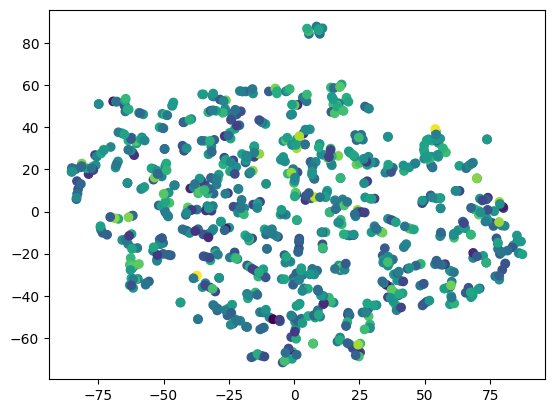

In [300]:
# make regression work
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, ConstantKernel
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



def from_model_to_score(model, X, y):
    # Define the number of folds for cross-validation
    r = cross_validate(model, X, y, cv=10, scoring=['r2',"neg_mean_absolute_error"], return_train_score=True)
    avg_r2 = np.mean(r['test_r2'])
    avg_mse = np.mean(r['test_neg_mean_absolute_error'])
    avg_r2_train = np.mean(r['train_r2'])
    avg_mse_train = np.mean(r['train_neg_mean_absolute_error'])
    print("TEST")
    print(f"R2 test: {avg_r2}")
    print(f"NMAE test: {avg_mse}")
    print("TRAIN")
    print(f"R2 train: {avg_r2_train}")
    print(f"NMAE train: {avg_mse_train}")
    return r

# 'additive_chi2', 'precomputed', 'linear', 'chi2', 'polynomial', 'sigmoid', 'laplacian', 'cosine', 'rbf', 'poly'}
#model = XGBRegressor(n_estimators=1000, max_depth=10, eta=0.01, subsample=1, colsample_bytree=1)
lasso = Lasso(alpha=0.000001, max_iter=1000)
svr_rbf = SVR(kernel="rbf", C=0.5, gamma=0.1, epsilon=0.1)
svr_lin = SVR(kernel="linear", C=100, gamma="auto")
svr_poly = SVR(kernel="poly", C=100, gamma="auto", degree=3, epsilon=0.1, coef0=1)
sgd = SGDRegressor(max_iter=1000, tol=1e-3)
huber = HuberRegressor(epsilon=3,max_iter=1000)
kn = KNeighborsRegressor(n_neighbors=10)

# noise terms
rf = RandomForestRegressor(n_estimators=10, max_depth=15) 

kernel = ConstantKernel(1.0, constant_value_bounds="fixed") # RBF() + WhiteKernel()
gau = GaussianProcessRegressor(kernel = kernel )
#model = KernelRidge(alpha=1, kernel='additive_chi2')
dt = DecisionTreeRegressor(max_depth=5)
mlp = MLPRegressor(random_state=1, max_iter=500)

t= StandardScaler()
#reduce = PCA(n_components=4)
reduce = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
dataset = routine
X = t.fit_transform(dataset[all_features].apply(lambda x: x + x.min(), axis=0))
X = reduce.fit_transform(X)
y = dataset['Eccentric'].apply(lambda x: x + 5) # overlreaning with rbf 
r = from_model_to_score(rf, X, y)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')

In [92]:
pos = data[all_features].apply(lambda x: x + x.max() +1, axis=0)
pos.columns[(pos < 0).any()]

Index([], dtype='object')

In [90]:
pos['fast_text_consecutive_cosine_sentences_similarity_mean'].describe()

count    1935.000000
mean        1.729739
std         0.062004
min        -0.065097
25%         1.701596
50%         1.733168
75%         1.761230
max         1.869806
Name: fast_text_consecutive_cosine_sentences_similarity_mean, dtype: float64

trajectory_score  reduction_score_PCA_explained_variance  \
0          2167.850276                                1.517666   
1          2028.236919                                1.532823   
2          2153.073794                                1.484903   
3          2304.419666                                1.326782   
4          2237.371169                                1.346137   
...                ...                                     ...   
2211       2032.598162                                1.529871   
2212       2398.415939                                1.332167   
2213       2269.589882                                1.394980   
2214       2143.224749                                1.510838   
2215       2213.853496                                1.449374   

      reduction_score_PCA_prop_of_components  cluster_density_score_HDBSCAN  \
0                                   1.222222                       0.600000   
1                                   1.400000                       0.600000   
2                                   1.400000                       1.100000   
3                                   1.250000                       1.011765   
4                                   1.200000                       0.850000   
...                                      ...                            ...   
2211                                1.333333                       0.600000   
2212                                1.272727                       0.850000   
2213                                1.272727                       0.766667   
2214                                1.333333                       1.028571   
2215                                1.285714                       0.975000   

      cluster_silhouette_score_HDBSCAN  \
0                             4.056571   
1                             4.056571   
2                             5.558860   
3                             5.640618   
4                             5.625218   
...                                ...   
2211                          4.056571   
2212                          4.765235   
2213                          5.581127   
2214                          4.818248   
2215                          5.418463   

      regression_coef_density_score_BayesianRidge  \
0                                             2.0   
1                                             2.0   
2                                             2.0   
3                                             2.0   
4                                             2.0   
...                                           ...   
2211                                          2.0   
2212                                          2.0   
2213                                          2.0   
2214                                          2.0   
2215                                          2.0   

      regression_coef_density_score_Lasso  reduction_score_Lasso  \
0                                1.900000               1.694737   
1                                2.000000               1.561404   
2                                2.000000               1.561404   
3                                1.705882               1.600619   
4                                1.562500               1.707237   
...                                   ...                    ...   
2211                             1.571429               1.466165   
2212                             1.666667               1.561404   
2213                             1.583333               1.478070   
2214                             1.714286               1.609023   
2215                             2.000000               1.644737   

      w2v_consecutive_cosine_sentences_similarity_mean  \
0                                             1.603820   
1                                             1.660691   
2                                             1.625587   
3                                             1.511952   
4              

In [28]:
np.sum(list(data[all_features].isna().sum()))

0

In [42]:
fitted_model = df_results[df_results['model_name'] == "ExplainableBoostingRegressor"].MODEL.values[0]

show(fitted_model.explain_global())

<!-- http://127.0.0.1:7001/129824801399232/ -->